## Tutorial - Measure sensitivity of explanations during model training

This tutorial demonstrates how one can use the library to evaluate how explanations changes while a model is training. We use a LeNet model and Fashion-MNIST dataset to showcase the library's functionality.

- Make sure to have GPUs enabled to speed up computation.
- Skip running the first cell if you do not use Google Colab.

In [ ]:
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install packages.
from IPython.display import clear_output
!pip install captum opencv-python
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
clear_output()

In [ ]:
# Imports general.
import sys
import gc
import warnings
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import captum
from captum.attr import *
import random
import os
import cv2

# Import package.
path = "/content/drive/MyDrive/Projects"
sys.path.append(f'{path}/quantus')
import quantus

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2
clear_output()

## 1. Preliminaries 

### 1.1 Load Fashion-MNIST dataset

In [ ]:
# Load datasets and make loaders.
transformer = augmentations =  transforms.Compose([transforms.RandomAffine(degrees=(0, 10), scale=(0.8, 1.1),
                                                                 interpolation=torchvision.transforms.InterpolationMode.NEAREST), 
                                         transforms.RandomHorizontalFlip(p=0.25),
                                         transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST(root='./sample_data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.FashionMNIST(root='./sample_data', train=False, transform=transformer, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True) # num_workers=4,
test_loader = torch.utils.data.DataLoader(test_set, batch_size=12, pin_memory=True)

# Specify class labels.
classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./sample_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./sample_data/FashionMNIST/raw


  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./sample_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./sample_data/FashionMNIST/raw


  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./sample_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./sample_data/FashionMNIST/raw


  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./sample_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./sample_data/FashionMNIST/raw
Processing...
Done!


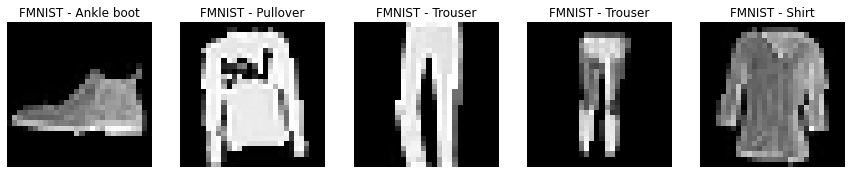

In [ ]:
# Plot some inputs!

nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for i in range(nr_images):
    axes[i].imshow(x_batch[i].cpu().numpy().reshape(28, 28), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"FMNIST - {classes[y_batch[i].item()]}")
    axes[i].axis("off")
plt.show()

## 2. Quantitative evaluation using Quantus

In [ ]:
class LeNet(torch.nn.Module):
     
    def __init__(self):   
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(16*5*5, 120)
        self.fc2 = torch.nn.Linear(120, 84)   
        self.fc3 = torch.nn.Linear(84, 10)    
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))  
        x = self.max_pool_1(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.max_pool_2(x)
        x = x.view(-1, 16*5*5)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Load model architecture.
model = LeNet()
print(f"\n Model architecture: {model.eval()}\n")


 Model architecture: LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)



### 2.1 Evaluate explanation robustness

During model training/ fine-tuning calculate max-sensitivity scores of Integrated Gradients explanations, as a measure of robustness.

In [ ]:
def evaluate_model(model, data, device):
    """Evaluate torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for b, (images, labels) in enumerate(data):  
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])

    return torch.nn.functional.softmax(logits, dim=1), targets
    
# Set necessary configs/ parameters.
model.to(device)  
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
path_model_weights = "drive/MyDrive/Projects/quantus/tutorials/assets/fashion_mnist"
epochs = 30
sensitivities = {}
 
for epoch in range(epochs):
    model.train()
    
    for b, (images, labels) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)
        logits = model(images)

        loss = criterion(logits, labels)
        model.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate model!
    predictions, labels = evaluate_model(model, test_loader, device)
    test_acc = np.mean(np.argmax(predictions.cpu().detach().numpy(), axis=1) == labels.detach().cpu().numpy())
    
    # Explain model (on a few test samples) and measure sensitivies.
    sensitivities[epoch] = sensitivities[epoch] = quantus.MaxSensitivity(**{"nr_samples": 10,
                                                                            "perturb_radius": 0.2,
                                                                            "norm_numerator": quantus.fro_norm,
                                                                            "norm_denominator": quantus.fro_norm,
                                                                            "explain_func": quantus.explain,
                                                                            "perturb_func": quantus.uniform_sampling,
                                                                            "similarity_func": quantus.difference,
                                                                        })(model=model, 
                                                                        x_batch=x_batch.cpu().numpy(),
                                                                        y_batch=y_batch.cpu().numpy(),
                                                                        a_batch=None,
                                                                        **{"method": "Saliency", "device": device, "img_size": 28}) 
                                                                            
    print(f"Epoch {epoch+1}/{epochs} - loss {loss.item():.2f} - test accuracy: {(100 * test_acc):.2f}% - max sensitivity {np.mean(sensitivities[epoch]):.2f}")

# Save model.
torch.save(model.state_dict(), path_model_weights)

Epoch 1/30 - loss 0.27 - test accuracy: 89.05% - max sensitivity 1.85
Epoch 2/30 - loss 0.18 - test accuracy: 89.13% - max sensitivity 1.76
Epoch 3/30 - loss 0.41 - test accuracy: 89.20% - max sensitivity 1.75
Epoch 4/30 - loss 0.39 - test accuracy: 89.55% - max sensitivity 1.53
Epoch 5/30 - loss 0.39 - test accuracy: 89.45% - max sensitivity 1.73
Epoch 6/30 - loss 0.24 - test accuracy: 89.75% - max sensitivity 1.83
Epoch 7/30 - loss 0.26 - test accuracy: 89.36% - max sensitivity 1.74
Epoch 8/30 - loss 0.21 - test accuracy: 89.56% - max sensitivity 1.74
Epoch 9/30 - loss 0.25 - test accuracy: 89.38% - max sensitivity 1.77
Epoch 10/30 - loss 0.24 - test accuracy: 89.62% - max sensitivity 1.76
Epoch 11/30 - loss 0.25 - test accuracy: 89.95% - max sensitivity 1.73
Epoch 12/30 - loss 0.42 - test accuracy: 89.89% - max sensitivity 1.87
Epoch 13/30 - loss 0.27 - test accuracy: 90.22% - max sensitivity 1.98
Epoch 14/30 - loss 0.36 - test accuracy: 90.29% - max sensitivity 1.99
Epoch 15/30 - l

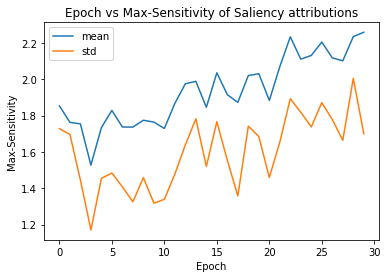

In [ ]:
# Summarise in a dataframe.      
df = pd.DataFrame()
df["mean"] = pd.DataFrame(sensitivities).mean(axis=0)
df["std"] = pd.DataFrame(sensitivities).std(axis=0)

# Plot!
df.plot.line(title="Epoch vs Max-Sensitivity of Saliency attributions", xlabel="Epoch", ylabel="Max-Sensitivity")